In [ ]:
#Student ID = 341

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize


In [46]:
result = np.column_stack((f1_X, f1_Y))
result
#8.40353417e-001,  2.64731614e-001,  3.34177101e-124
#0.830000-0.290000

array([[ 3.19403889e-001,  7.62959374e-001,  1.32267704e-079],
       [ 5.74329215e-001,  8.79898105e-001,  1.03307824e-046],
       [ 7.31023631e-001,  7.32999876e-001,  7.71087511e-016],
       [ 8.40353417e-001,  2.64731614e-001,  3.34177101e-124],
       [ 6.50114060e-001,  6.81526352e-001, -3.60606264e-003],
       [ 4.10437137e-001,  1.47554299e-001, -2.15924904e-054],
       [ 3.12691157e-001,  7.87227779e-002, -2.08909327e-091],
       [ 6.83418169e-001,  8.61057464e-001,  2.53500115e-040],
       [ 8.25072518e-002,  4.03487506e-001,  3.60677119e-081],
       [ 8.83889829e-001,  5.82253974e-001,  6.22985647e-048]])

In [2]:
f1_X = np.load('initial_data/function_1/initial_inputs.npy')
f1_Y = np.load('initial_data/function_1/initial_outputs.npy')

In [5]:
f1_X

array([[0.31940389, 0.76295937],
       [0.57432921, 0.8798981 ],
       [0.73102363, 0.73299988],
       [0.84035342, 0.26473161],
       [0.65011406, 0.68152635],
       [0.41043714, 0.1475543 ],
       [0.31269116, 0.07872278],
       [0.68341817, 0.86105746],
       [0.08250725, 0.40348751],
       [0.88388983, 0.58225397],
       [0.83      , 0.29      ],
       [0.619903  , 0.245888  ],
       [0.775021  , 0.265669  ],
       [0.549448  , 0.600462  ]])

In [4]:
#Week 1
f1_X = np.vstack((f1_X, np.array([0.83, 0.29])))
f1_Y = np.append(f1_Y, -3.2860097425164E-109)
#Week 2
f1_X = np.vstack((f1_X, np.array([0.619903,0.245888])))
f1_Y = np.append(f1_Y, -1.01694853412876E-50)
#Week 3
f1_X = np.vstack((f1_X, np.array([0.775021,0.265669])))
f1_Y = np.append(f1_Y, -1.24778222636534E-106)
#Week 4
f1_X = np.vstack((f1_X, np.array([0.549448,0.600462])))
f1_Y = np.append(f1_Y, -0.0000110332053603618)

In [32]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(f1_X, f1_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(1.0,1.0), bounds=x_bounds, method='L-BFGS-B')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)


0.549448-0.600462


/home/mathiascanales/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [10]:
# Create a Linear Regression model
model = LinearRegression(fit_intercept = True, n_jobs = 14)

# Train the model
model.fit(f1_X, f1_Y)

# Predict values of x for y ≈ 0
target_y = 0
predicted_x = (target_y - model.intercept_) / model.coef_

formatted_x = '-'.join([f'{x:.6f}' for x in predicted_x])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.775021-0.265669


Best parameters found:  OrderedDict([('fit_intercept', True), ('n_jobs', 14)])
Best score found:  -6.650252232000984e+92


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

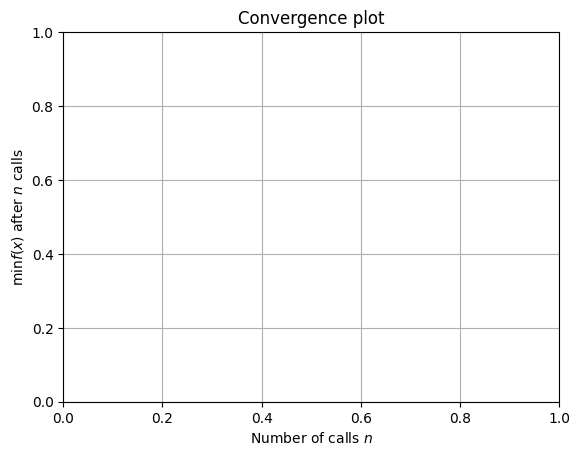

In [9]:
regressor = LinearRegression()

# Define the search space for Bayesian optimization
param_space = {
    'fit_intercept': [True, False],
    'n_jobs': [1, 20],  
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    regressor,
    param_space,
    n_iter=10,  # Number of optimization iterations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    random_state=0,
    n_points=5,  # Initial points to sample
)

opt.fit(f1_X, f1_Y)

# Print the best hyperparameters and model performance
print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)


In [6]:
# Train a machine learning model (Random Forest regressor) as a surrogate
surrogate_model = RandomForestRegressor(n_estimators=100, random_state=42)
surrogate_model.fit(f1_X, f1_Y)

space = {
    'n_estimators': np.arange(10, 30),
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10)
}

# Create the Bayesian optimization object
opt = BayesSearchCV(
    surrogate_model,
    search_spaces=space,
    n_iter=10,  # Adjust the number of iterations as needed
    random_state=42,  # Set a random seed for reproducibility
    n_jobs=-1,  # Use all available CPU cores for parallel optimization
    #acquisition_optimizer='sampling',  # Use sampling-based acquisition optimization
    #acquisition_function="EI",  # Use Expected Improvement acquisition function
    verbose=1  # Increase verbosity for more details during optimization
)

# Fit the optimizer
opt.fit(f1_X,f1_Y)

# Get the best-found parameters
best_params = opt.best_params_
best_predicted_value = -opt.best_score_

print("Best Parameters:", best_params)
print("Best Predicted Value:", best_predicted_value)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict([('max_depth', 7), ('min_samples_leaf', 9), ('min_samples_split', 3), ('n_estimators', 14)])
Best Predicted Value: 1.7005732072040707e+100


In [20]:
# Create a Linear Regression model
model = RandomForestRegressor()

# Train the model
model.fit(f1_X, f1_Y)

param1_values = np.linspace(0, 1, 100)  # Adjust the range and step size for the first parameter
param2_values = np.linspace(0, 1, 100)  # Adjust the range and step size for the second parameter

# Initialize variables to keep track of the maximum prediction and corresponding input values
max_prediction = -float("inf")
best_input_values = None

# Loop through the candidate input values and make predictions
for param1_value in param1_values:
    for param2_value in param2_values:
        # Create an input vector (assuming f1_X is a 2D array)
        input_vector = np.array([param1_value, param2_value]).reshape(1, -1)
        
        # Make a prediction using the model
        prediction = model.predict(input_vector)

        # Check if this prediction is the maximum so far
        if prediction > max_prediction:
            max_prediction = prediction
            best_input_values = input_vector

# At this point, best_input_values contains the input values that result in the maximum prediction
print("Maximum Prediction:", max_prediction)
print("Corresponding Input Values:", best_input_values)

Maximum Prediction: [-3.60606264e-05]
Corresponding Input Values: [[0.         0.77777778]]


In [33]:
f2_X = np.load('initial_data/function_2/initial_inputs.npy')
f2_Y = np.load('initial_data/function_2/initial_outputs.npy')
result = np.column_stack((f2_X, f2_Y))
result
#0.710000-0.990000

array([[ 0.66579958,  0.12396913,  0.53899612],
       [ 0.87779099,  0.7786275 ,  0.42058624],
       [ 0.14269907,  0.34900513, -0.06562362],
       [ 0.84527543,  0.71112027,  0.29399291],
       [ 0.45464714,  0.29045518,  0.21496451],
       [ 0.57771284,  0.77197318,  0.02310555],
       [ 0.43816606,  0.68501826,  0.24461934],
       [ 0.34174959,  0.02869772,  0.03874902],
       [ 0.33864816,  0.21386725, -0.01385762],
       [ 0.70263656,  0.9265642 ,  0.61120522]])

In [34]:
#Week 1
f2_X = np.vstack((f2_X, np.array([0.71, 0.99])))
f2_Y = np.append(f2_Y, 0.584747960355965)
#Week 2
f2_X = np.vstack((f2_X, np.array([0.87779,0.99])))
f2_Y = np.append(f2_Y, 0.200034882833225)
#Week 3
f2_X = np.vstack((f2_X, np.array([0.877791,0.99])))
f2_Y = np.append(f2_Y, -0.065322598998729)
#Week 4
f2_X = np.vstack((f2_X, np.array([0.883564,0.99])))
f2_Y = np.append(f2_Y, 0.08297567384)

In [35]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(f2_X, f2_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(1.0,1.0), bounds=x_bounds, method='L-BFGS-B')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

0.883564-0.990000


/home/mathiascanales/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [19]:
regressor = LinearRegression()

# Define the search space for Bayesian optimization
param_space = {
    'fit_intercept': [True, False],
    'n_jobs': [1, 20],  
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    regressor,
    param_space,
    n_iter=10,  # Number of optimization iterations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    random_state=0,
    n_points=5,  # Initial points to sample
)

opt.fit(f2_X, f2_Y)

best_model = opt.best_estimator_

def objective_function(x):
    x1, x2 = x
    x = np.array([[x1, x2]])  # Reshape x into a 2D array
    predicted_Y = best_model.predict(x)  # Predict Y for the given x
    return -predicted_Y

# Optimize the objective function to find x that maximizes Y
result = minimize(objective_function, x0=(0.0, 0.0), bounds=[(0.0, 1.0), (0.0, 1.0)])  # Adjust bounds as needed

# The result will contain the optimized x value that maximizes Y
optimal_x = result.x

In [20]:
optimal_x

array([1., 1.])

In [22]:
from scipy.stats import linregress

# Perform linear regression for each feature
n_features = f2_X.shape[1]
slopes = []
intercepts = []

for feature_index in range(n_features):
    slope, intercept, _, _, _ = linregress(f2_X[:, feature_index], f2_Y)
    slopes.append(slope)
    intercepts.append(intercept)

# Calculate maximum y within the x range
x_maximizing_y = []

for feature_index in range(n_features):
    x_min = min(f2_X[:, feature_index])
    x_max = max(f2_X[:, feature_index])
    y_max = max(intercepts[feature_index] + slopes[feature_index] * x_min, intercepts[feature_index] + slopes[feature_index] * x_max)
    
    # Calculate corresponding x for the maximum y
    x_maximizing_y.append((y_max - intercepts[feature_index]) / slopes[feature_index])
x_maximizing_y
formatted_x = '-'.join([f'{x:.6f}' for x in x_maximizing_y])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.877791-0.990000


In [36]:
f3_X = np.load('initial_data/function_3/initial_inputs.npy')
f3_Y = np.load('initial_data/function_3/initial_outputs.npy')
result = np.column_stack((f3_X, f3_Y))
result
0.49258141,  0.61159319,  0.34017639
0.60009728,  0.72513573,  0.06608864
0.540000-0.650000-0.200000

-0.31

In [37]:
#Week 1
f3_X = np.vstack((f3_X, np.array([0.54,0.65,0.2])))
f3_Y = np.append(f3_Y, -0.1309050532)
#Week 2
f3_X = np.vstack((f3_X, np.array([0.718668,0.999945,0.272151])))
f3_Y = np.append(f3_Y, -0.1413686626)
#Week 3
f3_X = np.vstack((f3_X, np.array([0.596189,0.614615,0.214115])))
f3_Y = np.append(f3_Y, -0.11486006842883)
#Week 4
f3_X = np.vstack((f3_X, np.array([0.124154,0.849855,0.738203])))
f3_Y = np.append(f3_Y, -0.142476683810238)

In [46]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f3_X, f3_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(1.0,0.0,1.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

-0.124154-0.849855-1.738203


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [27]:
regressor = LinearRegression()

# Define the search space for Bayesian optimization
param_space = {
    'fit_intercept': [True, False],
    'n_jobs': [1, 20],  
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    regressor,
    param_space,
    n_iter=10,  # Number of optimization iterations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    random_state=0,
    n_points=5,  # Initial points to sample
)

opt.fit(f3_X, f3_Y)

# Print the best hyperparameters and model performance
print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)


Best parameters found:  OrderedDict([('fit_intercept', False), ('n_jobs', 1)])
Best score found:  -2.289614982211238


In [29]:
# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(f3_X, f3_Y)

# Predict values of x for y ≈ 0
target_y = 0
predicted_x = (target_y - model.intercept_) / model.coef_

formatted_x = '-'.join([f'{x:.6f}' for x in predicted_x])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.596189--0.614615--0.214115


In [47]:
f4_X = np.load('initial_data/function_4/initial_inputs.npy')
f4_Y = np.load('initial_data/function_4/initial_outputs.npy')
result = np.column_stack((f4_X, f4_Y))
result
#1.24871181e-01,  1.29770193e-01,  3.84400483e-01 , 2.87076101e-01, -1.00696334e+01
# 2.47708262e-01,  6.04454273e-02,  4.21863451e-02, 4.41324251e-01, -1.26816850e+01
# 0.120000-0.1010000-0.360000-0.2400000

array([[ 8.96981054e-01,  7.25627970e-01,  1.75404309e-01,
         7.01694369e-01, -2.21082878e+01],
       [ 8.89356396e-01,  4.99587855e-01,  5.39268858e-01,
         5.08783439e-01, -1.46013966e+01],
       [ 2.50946243e-01,  3.36931305e-02,  1.45380025e-01,
         4.94932421e-01, -1.16999325e+01],
       [ 3.46962061e-01,  6.25040024e-03,  7.60563606e-01,
         6.13023557e-01, -1.60537651e+01],
       [ 1.24871181e-01,  1.29770193e-01,  3.84400483e-01,
         2.87076101e-01, -1.00696334e+01],
       [ 8.01302707e-01,  5.00231094e-01,  7.06644560e-01,
         1.95102841e-01, -1.54870825e+01],
       [ 2.47708262e-01,  6.04454273e-02,  4.21863451e-02,
         4.41324251e-01, -1.26816850e+01],
       [ 7.46702242e-01,  7.57091504e-01,  3.69353060e-01,
         2.06566281e-01, -1.60263998e+01],
       [ 4.00665027e-01,  7.25742511e-02,  8.86768254e-01,
         2.43842290e-01, -1.70492346e+01],
       [ 6.26070596e-01,  5.86751259e-01,  4.38805782e-01,
         7.78857694e-01

In [48]:
#Week 1
f4_X = np.vstack((f4_X, np.array([0.12,0.101,0.36,0.24])))
f4_Y = np.append(f4_Y, -10.2679334484568)
#Week 2
f4_X = np.vstack((f4_X, np.array([0.401067,0.465459,0.990034,0.337921])))
f4_Y = np.append(f4_Y, -17.45206644)
#Week 3
f4_X = np.vstack((f4_X, np.array([0.398924,0.448872,0.912348,0.328706])))
f4_Y = np.append(f4_Y, -14.27743893)
#Week 4
f4_X = np.vstack((f4_X, np.array([0.961534,0.902131,0.835173,0.600658])))
f4_Y = np.append(f4_Y, -33.189198584856)

In [49]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1), (0,1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f4_X, f4_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(1.0,1.0,1.0,1.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

0.961534-0.902131-0.835173-0.600658


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [32]:
regressor = LinearRegression()

# Define the search space for Bayesian optimization
param_space = {
    'fit_intercept': [True, False],
    'n_jobs': [1, 20],  
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    regressor,
    param_space,
    n_iter=10,  # Number of optimization iterations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    random_state=0,
    n_points=5,  # Initial points to sample
)

opt.fit(f4_X, f4_Y)

# Print the best hyperparameters and model performance
print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)

Best parameters found:  OrderedDict([('fit_intercept', True), ('n_jobs', 14)])
Best score found:  0.09810334907778417


In [33]:
# Create a Linear Regression model
model = LinearRegression(fit_intercept = True, n_jobs = 14)

# Train the model
model.fit(f4_X, f4_Y)

# Predict values of x for y ≈ 0
target_y = 0
predicted_x = (target_y - model.intercept_) / model.coef_

formatted_x = '-'.join([f'{x:.6f}' for x in predicted_x])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: -0.398924--0.448872--1.234869--0.328706


In [50]:
f5_X = np.load('initial_data/function_5/initial_inputs.npy')
f5_Y = np.load('initial_data/function_5/initial_outputs.npy')
result = np.column_stack((f5_X, f5_Y))
result
#2.24189023e-01, 8.46480490e-01, 8.79484180e-01, 8.78515684e-01,1.08885962e+03
#0.230000-0.900000-0.800000-0.900000

array([[1.91447084e-01, 3.81933714e-02, 6.07417811e-01, 4.14584137e-01,
        6.44434399e+01],
       [7.58652949e-01, 5.36517738e-01, 6.56000382e-01, 3.60341553e-01,
        1.83013796e+01],
       [4.38349873e-01, 8.04339705e-01, 2.10245266e-01, 1.51294816e-01,
        1.12939795e-01],
       [7.06050834e-01, 5.34191961e-01, 2.64243345e-01, 4.82087549e-01,
        4.21089813e+00],
       [8.36477993e-01, 1.93609647e-01, 6.63892697e-01, 7.85648883e-01,
        2.58370525e+02],
       [6.83432250e-01, 1.18662642e-01, 8.29045910e-01, 5.67576606e-01,
        7.84343889e+01],
       [5.53621480e-01, 6.67349979e-01, 3.23805819e-01, 8.14869754e-01,
        5.75715369e+01],
       [3.52356269e-01, 3.22241532e-01, 1.16979368e-01, 4.73112522e-01,
        1.09571876e+02],
       [1.53785706e-01, 7.29381690e-01, 4.22598437e-01, 4.43074166e-01,
        8.84799176e+00],
       [4.63442267e-01, 6.30024510e-01, 1.07906456e-01, 9.57643899e-01,
        2.33223610e+02],
       [6.77491148e-01, 3.5850

In [51]:
#Week 1
f5_X = np.vstack((f5_X, np.array([0.23,0.9,0.8,0.9])))
f5_Y = np.append(f5_Y, 1113.607380032)
#Week 2
f5_X = np.vstack((f5_X, np.array([0.119879,0.9,0.879484,0.957644])))
f5_Y = np.append(f5_Y, 1854.055026)
#Week 3
#Same input
#Week 4
f5_X = np.vstack((f5_X, np.array([0.781781,0.621022,0.901272,0.827289])))
f5_Y = np.append(f5_Y, 1000.424187)

In [55]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1), (0,1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f5_X, f5_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(0.0,0.0,0.0,0.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

-0.781781--0.621022--0.901272--0.827289


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [36]:
# Perform linear regression for each feature
n_features = f5_X.shape[1]
slopes = []
intercepts = []

for feature_index in range(n_features):
    slope, intercept, _, _, _ = linregress(f5_X[:, feature_index], f5_Y)
    slopes.append(slope)
    intercepts.append(intercept)

# Calculate maximum y within the x range
x_maximizing_y = []

for feature_index in range(n_features):
    x_min = min(f5_X[:, feature_index])
    x_max = max(f5_X[:, feature_index])
    y_max = max(intercepts[feature_index] + slopes[feature_index] * x_min, intercepts[feature_index] + slopes[feature_index] * x_max)
    
    # Calculate corresponding x for the maximum y
    x_maximizing_y.append((y_max - intercepts[feature_index]) / slopes[feature_index])
formatted_x = '-'.join([f'{x:.6f}' for x in x_maximizing_y])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.119879-0.900000-0.879484-0.957644


In [56]:
f6_X = np.load('initial_data/function_6/initial_inputs.npy')
f6_Y = np.load('initial_data/function_6/initial_outputs.npy')
result = np.column_stack((f6_X, f6_Y))
result
#0.7281861 ,  0.15469257,  0.73255167,  0.69399651,  0.05640131,-0.71426495
#0.710000-0.160000-0.750000-0.670000-0.090000

array([[ 0.7281861 ,  0.15469257,  0.73255167,  0.69399651,  0.05640131,
        -0.71426495],
       [ 0.24238435,  0.84409997,  0.5778091 ,  0.67902128,  0.50195289,
        -1.20995524],
       [ 0.72952261,  0.7481062 ,  0.67977464,  0.35655228,  0.67105368,
        -1.67219994],
       [ 0.77062024,  0.11440374,  0.04677993,  0.64832428,  0.27354905,
        -1.53605771],
       [ 0.6188123 ,  0.33180214,  0.18728787,  0.75623847,  0.3288348 ,
        -0.82923655],
       [ 0.78495809,  0.91068235,  0.7081201 ,  0.95922543,  0.0049115 ,
        -1.24704893],
       [ 0.14511079,  0.8966846 ,  0.89632223,  0.72627154,  0.23627199,
        -1.23378638],
       [ 0.94506907,  0.28845905,  0.97880576,  0.96165559,  0.59801594,
        -1.69434344],
       [ 0.12572016,  0.86272469,  0.02854433,  0.24660527,  0.75120624,
        -2.57116963],
       [ 0.75759436,  0.35583141,  0.0165229 ,  0.4342072 ,  0.11243304,
        -1.30911635],
       [ 0.5367969 ,  0.30878091,  0.41187929,  0.

In [58]:
#Week 1
f6_X = np.vstack((f6_X, np.array([0.71,0.16,0.75,0.67,0.09])))
f6_Y = np.append(f6_Y, -0.703723755592536)
#Week 2
f6_X = np.vstack((f6_X, np.array([0.237921,0.191643,0.308479,0.169956,0.1230565])))
f6_Y = np.append(f6_Y, -1.35038509342459)
#Week 3
f6_X = np.vstack((f6_X, np.array([0.291906,0.224345,0.332472,0.174037,0.1414308])))
f6_Y = np.append(f6_Y, -1.25771372725334)
#Week 4
f6_X = np.vstack((f6_X, np.array([0.087971,0.967504,0.160638,0.054875,0.927092])))
f6_Y = np.append(f6_Y, -2.979991547)

In [59]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1), (0,1), (0,1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f6_X, f6_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(0.0,0.0,0.0,0.0,0.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

0.087971-0.967504--0.160638-0.054875-0.927092


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [39]:
regressor = LinearRegression()

# Define the search space for Bayesian optimization
param_space = {
    'fit_intercept': [True, False],
    'n_jobs': [1, 20],  
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    regressor,
    param_space,
    n_iter=10,  # Number of optimization iterations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    random_state=0,
    n_points=5,  # Initial points to sample
)

opt.fit(f6_X, f6_Y)

# Print the best hyperparameters and model performance
print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)

Best parameters found:  OrderedDict([('fit_intercept', True), ('n_jobs', 14)])
Best score found:  0.27121678604740984


In [40]:
# Create a Linear Regression model
model = LinearRegression(fit_intercept = True, n_jobs =14)

# Train the model
model.fit(f6_X, f6_Y)

# Predict values of x for y ≈ 0
target_y = 0
predicted_x = (target_y - model.intercept_) / model.coef_

formatted_x = '-'.join([f'{x:.6f}' for x in predicted_x])

print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: -2.919064--2.243456-3.324729-1.740374--1.414308


In [60]:
f7_X = np.load('initial_data/function_7/initial_inputs.npy')
f7_Y = np.load('initial_data/function_7/initial_outputs.npy')
result = np.column_stack((f7_X, f7_Y))
result
#0.27262382, 0.32449536, 0.89710881, 0.83295115, 0.15406269,0.79586362, 0.6044327 
#0.250000-0.330000-0.850000-0.830000-0.200000-0.750000

array([[0.27262382, 0.32449536, 0.89710881, 0.83295115, 0.15406269,
        0.79586362, 0.6044327 ],
       [0.54300258, 0.9246939 , 0.34156746, 0.64648585, 0.71844033,
        0.34313266, 0.56275307],
       [0.09083225, 0.66152938, 0.06593091, 0.25857701, 0.96345285,
        0.6402654 , 0.00750324],
       [0.11886697, 0.61505494, 0.90581639, 0.8553003 , 0.41363143,
        0.58523563, 0.0614243 ],
       [0.63021764, 0.8380969 , 0.68001305, 0.73189509, 0.52673671,
        0.34842921, 0.2730468 ],
       [0.76491917, 0.25588292, 0.60908422, 0.21807904, 0.32294277,
        0.09579366, 0.08374657],
       [0.05789554, 0.49167222, 0.24742222, 0.21811844, 0.42042833,
        0.73096984, 1.3649683 ],
       [0.19525188, 0.07922665, 0.55458046, 0.17056682, 0.01494418,
        0.10703171, 0.09264495],
       [0.64230298, 0.83687455, 0.02179269, 0.10148801, 0.68307083,
        0.6924164 , 0.0178696 ],
       [0.78994255, 0.19554501, 0.57562333, 0.07365919, 0.25904917,
        0.05109986, 0.0

In [61]:
#Week 1
f7_X = np.vstack((f7_X, np.array([0.25,0.33,0.85,0.83,0.2,0.75])))
f7_Y = np.append(f7_Y, 0.50227388554458)
#Week 2
f7_X = np.vstack((f7_X, np.array([0.057896,0.924694,0.924571,0.073659,0.014944,0.951014])))
f7_Y = np.append(f7_Y, 0.0850275940993777)
#Week 3
f7_X = np.vstack((f7_X, np.array([0.067896,0.824694,0.724571,0.063659,0.034944,0.851014])))
f7_Y = np.append(f7_Y, 0.218179252964693)
#Week 4
f7_X = np.vstack((f7_X, np.array([0.822203,0.905431,0.608675,0.131364,0.711093,0.392675])))
f7_Y = np.append(f7_Y, 0.008208888021)

In [62]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1), (0,1), (0,1), (0,1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f7_X, f7_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(0.0,0.0,0.0,0.0,0.0, 0.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

0.822203-1.054314-0.608675--0.131364--0.711093-0.392675


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [43]:
# Perform linear regression for each feature
n_features = f7_X.shape[1]
slopes = []
intercepts = []

for feature_index in range(n_features):
    slope, intercept, _, _, _ = linregress(f7_X[:, feature_index], f7_Y)
    slopes.append(slope)
    intercepts.append(intercept)

# Calculate maximum y within the x range
x_maximizing_y = []

for feature_index in range(n_features):
    x_min = min(f7_X[:, feature_index])
    x_max = max(f7_X[:, feature_index])
    y_max = max(intercepts[feature_index] + slopes[feature_index] * x_min, intercepts[feature_index] + slopes[feature_index] * x_max)
    
    # Calculate corresponding x for the maximum y
    x_maximizing_y.append((y_max - intercepts[feature_index]) / slopes[feature_index])

formatted_x = '-'.join([f'{x:.6f}' for x in x_maximizing_y])
print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.057896-0.924694-0.924571-0.073659-0.014944-0.951014


In [63]:
f8_X = np.load('initial_data/function_8/initial_inputs.npy')
f8_Y = np.load('initial_data/function_8/initial_outputs.npy')
result = np.column_stack((f8_X, f8_Y))
result
#4.43292532e-02, 1.35814872e-02, 2.58198240e-01, 5.77644163e-01,5.12799230e-02, 1.58563071e-01, 5.91030124e-01, 7.79529335e-02,9.01307515e+00
#4.81245331e-01, 1.02460721e-01, 2.19485939e-01, 6.77322369e-01,2.47509187e-01, 2.44340858e-01, 1.63824527e-01, 7.15961640e-01,9.18300525e+00
#0.200000-0.400000-0.2350000-0.625000-0.120000-0.210000-0.380000-0.350000

array([[6.04994453e-01, 2.92215020e-01, 9.08452748e-01, 3.55506242e-01,
        2.01668719e-01, 5.75338005e-01, 3.10310951e-01, 7.34281377e-01,
        7.39872110e+00],
       [1.78006959e-01, 5.66222654e-01, 9.94861845e-01, 2.10325006e-01,
        3.20152657e-01, 7.07908792e-01, 6.35384489e-01, 1.07131627e-01,
        7.00522736e+00],
       [9.07697668e-03, 8.11626153e-01, 5.20520360e-01, 7.56866752e-02,
        2.65111825e-01, 9.16516894e-02, 5.92415145e-01, 3.67320262e-01,
        8.45948162e+00],
       [5.06028164e-01, 6.53730123e-01, 3.63410779e-01, 1.77981049e-01,
        9.37283044e-02, 1.97425331e-01, 7.55826900e-01, 2.92472339e-01,
        8.28400781e+00],
       [3.59909264e-01, 2.49075679e-01, 4.95997170e-01, 7.09214981e-01,
        1.14987195e-01, 2.89206921e-01, 5.57295151e-01, 5.93881726e-01,
        8.60611679e+00],
       [7.78818344e-01, 3.41949948e-03, 3.37983130e-01, 5.19527778e-01,
        8.20906993e-01, 5.37246689e-01, 5.51347098e-01, 6.60032086e-01,
        8.5

In [64]:
#Week 1
f8_X = np.vstack((f8_X, np.array([0.2,0.4,0.235,0.625,0.12,0.21,0.38,0.35])))
f8_Y = np.append(f8_Y, 9.27245)
#Week 2
f8_X = np.vstack((f8_X, np.array([0.009077,0.003419,0.022929,0.009043,0.009649,0.990244,0.035909,0.988755])))
f8_Y = np.append(f8_Y, 9.286087265)
#Week 3
#Same input
#Week 4
f8_X = np.vstack((f8_X, np.array([0.092456,0.271979,0.044189,0.249986,0.53335,0.540113,0.19916,0.544261])))
f8_Y = np.append(f8_Y, 9.915447257)

In [66]:
# Define the surrogate function using a Gaussian Process
def surrogate_function(x, gp):
    mu, _ = gp.predict(np.array([x]), return_std=True)
    return -mu[0]

x_bounds = [(0, 1), (0, 1), (0, 1), (0,1), (0,1), (0,1),(0,1), (0,1)]

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

gp.fit(f8_X, f8_Y)
result = minimize(lambda x: -surrogate_function(x, gp), x0=(0.0,0.0,0.0,0.0,0.0, 0.0, 0.0,0.0), bounds=x_bounds, method='BFGS')

formatted_x = '-'.join([f'{x:.6f}' for x in result.x])
print(formatted_x)

-0.601182--4.566766--0.173059--6.834764--9.830308--10.744623--6.171214--10.466004


/home/mathiascanales/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [46]:
# Perform linear regression for each feature
n_features = f8_X.shape[1]
slopes = []
intercepts = []

for feature_index in range(n_features):
    slope, intercept, _, _, _ = linregress(f8_X[:, feature_index], f8_Y)
    slopes.append(slope)
    intercepts.append(intercept)

# Calculate maximum y within the x range
x_maximizing_y = []

for feature_index in range(n_features):
    x_min = min(f8_X[:, feature_index])
    x_max = max(f8_X[:, feature_index])
    y_max = max(intercepts[feature_index] + slopes[feature_index] * x_min, intercepts[feature_index] + slopes[feature_index] * x_max)
    
    # Calculate corresponding x for the maximum y
    x_maximizing_y.append((y_max - intercepts[feature_index]) / slopes[feature_index])

formatted_x = '-'.join([f'{x:.6f}' for x in x_maximizing_y])
print(f"Predicted x for y ≈ 0: {formatted_x}")

Predicted x for y ≈ 0: 0.009077-0.003419-0.022929-0.009043-0.009649-0.990244-0.035909-0.988755
